In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/gdrive/MyDrive/BDA_project/train.csv')

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')  # 나눔바른고딕 적용하기

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# 칼럼 분석

*   id: 해당 데이터의 고유한 ID
*   route_id: 버스 노선 id
*   vh_id: 버스 id
*   route_nm: 버스 노선 실제 번호
*   now_latitude: 현재 위치의 위도
*   now_latitude: 현재 위치의 위도
*   now_station: 현재 정거장 이름
*   now_arrive_time: 현재 정거장에 도착한 시간
*   distance: 현재 위치에서 다음 정거장까지의 거리
*   next_station: 다음 정거장 이름
*   next_latitude: 다음 정거장의 위도 정보
*   next_longitude: 다음 정거장의 경도 정보
*   next_arrive_time: 다음 정거장까지 걸린 시간 (초 단위)


In [ ]:
# 불필요한 컬럼 삭제
columns_to_drop = [ 'now_latitude', 'now_longitude','next_latitude','next_longitude']
df = df.drop(columns=columns_to_drop)

## 전처리 접근방식

- 요일별
- 시간대별(아침, 점심, 저녁, 새벽)
- 걸린 시간별
- 걸린 거리별

In [ ]:
# 필요한 컬럼들 생성 (요일, 1미터당 걸린 시간(초), 1초당 걸린 거리(m) 계산하여 컬럼화)

df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.day_name()

df['distance'] = df['distance'].astype(int)
df['s/m'] = df['next_arrive_time'] / df['distance']
df['m/s'] = df['distance'] / df['next_arrive_time']
df['time']='time'

In [ ]:
df

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time
0,0,2019-10-15,405136001,7997025,360-1,제주대학교입구,06시,266,제대마을,24,Tuesday,0.090226,11.083333,time
1,1,2019-10-15,405136001,7997025,360-1,제대마을,06시,333,제대아파트,36,Tuesday,0.108108,9.250000,time
2,2,2019-10-15,405136001,7997025,360-1,제대아파트,06시,415,제주대학교,40,Tuesday,0.096386,10.375000,time
3,3,2019-10-15,405136001,7997025,360-1,남국원(아라방면),06시,578,제주여자중고등학교(아라방면),42,Tuesday,0.072664,13.761905,time
4,4,2019-10-15,405136001,7997025,360-1,도호동,07시,374,은남동,64,Tuesday,0.171123,5.843750,time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,비석거리,21시,528,삼아아파트,96,Monday,0.181818,5.500000,time
210453,210453,2019-10-28,405328102,7983486,281-2,동문로터리,21시,280,매일올레시장 7번입구,50,Monday,0.178571,5.600000,time
210454,210454,2019-10-28,405328102,7983486,281-2,서귀포시 구 버스터미널,21시,114,아랑조을거리 입구,16,Monday,0.140351,7.125000,time
210455,210455,2019-10-28,405328102,7983486,281-2,아랑조을거리 입구,21시,223,평생학습관,38,Monday,0.170404,5.868421,time


In [ ]:
# 요일별 분포와 버스 운행 횟수 확인

df.groupby('date')['week'].value_counts()

# 발견 1 : 요일이 두 번씩 반복
# 발견 2 : 주말에는 운행 횟수가 줄어듦 >> 배차 간격의 문제 고려

date        week     
2019-10-15  Tuesday      15980
2019-10-16  Wednesday    15464
2019-10-17  Thursday     15889
2019-10-18  Friday       15084
2019-10-19  Saturday     14975
2019-10-20  Sunday       14291
2019-10-21  Monday       15933
2019-10-22  Tuesday      15331
2019-10-23  Wednesday    15354
2019-10-24  Thursday     15079
2019-10-25  Friday       14919
2019-10-26  Saturday     13831
2019-10-27  Sunday       13907
2019-10-28  Monday       14420
Name: week, dtype: int64

# distance 통일하기!

같은 버스 정류장인데 노선에 따라서 거리가 조금씩 다르게 측정되었다.
노선이 다르더라도 now_station과 next_station이 같다면 같은 거리로 측정할 필요성이 있었다.

->평균으로 대체

In [ ]:
station_group = df.groupby(['now_station','next_station'])['distance'].mean().reset_index(name='distance_mean')

In [ ]:
station_group

,now_station,next_station,distance_mean
0,911의원,북촌리해동,905.695652
1,911의원,함덕리 4구,457.000000
2,911의원,함덕리(4구),344.000000
3,LH아파트,광대왓,648.000000
4,가마초등학교,샤인빌리조트입구,552.432836
...,...,...,...
719,효례교,효돈중학교,241.000000
720,흙통,답다니,422.101124
721,흙통,오희준 공원,489.000000
722,희진주유소,삼달교차로,1052.200000


In [ ]:
for i in range(0, 724):
    mask = (df['now_station'] == station_group.iloc[i, 0]) & (df['next_station'] == station_group.iloc[i, 1])
    df.loc[mask, 'distance'] = station_group.iloc[i, 2]

In [ ]:
df

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time
0,0,2019-10-15,405136001,7997025,360-1,제주대학교입구,06시,266.000000,제대마을,24,Tuesday,0.090226,11.083333,time
1,1,2019-10-15,405136001,7997025,360-1,제대마을,06시,333.265436,제대아파트,36,Tuesday,0.108108,9.250000,time
2,2,2019-10-15,405136001,7997025,360-1,제대아파트,06시,420.903308,제주대학교,40,Tuesday,0.096386,10.375000,time
3,3,2019-10-15,405136001,7997025,360-1,남국원(아라방면),06시,578.000000,제주여자중고등학교(아라방면),42,Tuesday,0.072664,13.761905,time
4,4,2019-10-15,405136001,7997025,360-1,도호동,07시,322.581998,은남동,64,Tuesday,0.171123,5.843750,time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,비석거리,21시,526.655462,삼아아파트,96,Monday,0.181818,5.500000,time
210453,210453,2019-10-28,405328102,7983486,281-2,동문로터리,21시,280.000000,매일올레시장 7번입구,50,Monday,0.178571,5.600000,time
210454,210454,2019-10-28,405328102,7983486,281-2,서귀포시 구 버스터미널,21시,114.000000,아랑조을거리 입구,16,Monday,0.140351,7.125000,time
210455,210455,2019-10-28,405328102,7983486,281-2,아랑조을거리 입구,21시,219.256538,평생학습관,38,Monday,0.170404,5.868421,time


아침, 점심, 저녁 나누기

<Axes: >

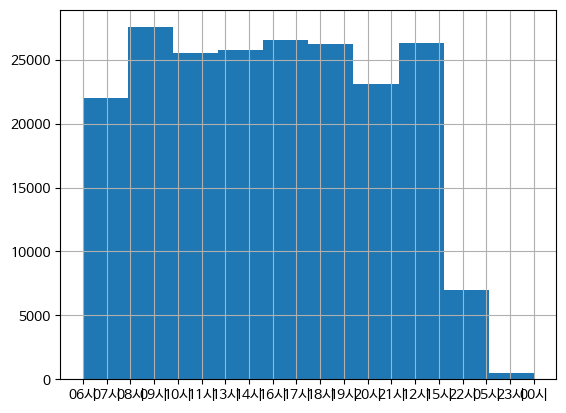

In [ ]:
times_ = df['now_arrive_time']

times_.hist() #6시~0시까지 존재

In [ ]:
df.loc[ (df['now_arrive_time'] >='05시') & (df['now_arrive_time'] <'12시') ,['time'] ]= 'morning' # 05~11시
df.loc[ (df['now_arrive_time'] >='12시') & (df['now_arrive_time'] <'18시') ,['time'] ]= 'afternoon' # 12~17시
df.loc[ (df['now_arrive_time'] >='18시') | (df['now_arrive_time'] =='00시') ,['time'] ]= 'evening' # 18~0시
df

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time
0,0,2019-10-15,405136001,7997025,360-1,제주대학교입구,06시,266.000000,제대마을,24,Tuesday,0.090226,11.083333,morning
1,1,2019-10-15,405136001,7997025,360-1,제대마을,06시,333.265436,제대아파트,36,Tuesday,0.108108,9.250000,morning
2,2,2019-10-15,405136001,7997025,360-1,제대아파트,06시,420.903308,제주대학교,40,Tuesday,0.096386,10.375000,morning
3,3,2019-10-15,405136001,7997025,360-1,남국원(아라방면),06시,578.000000,제주여자중고등학교(아라방면),42,Tuesday,0.072664,13.761905,morning
4,4,2019-10-15,405136001,7997025,360-1,도호동,07시,322.581998,은남동,64,Tuesday,0.171123,5.843750,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,비석거리,21시,526.655462,삼아아파트,96,Monday,0.181818,5.500000,evening
210453,210453,2019-10-28,405328102,7983486,281-2,동문로터리,21시,280.000000,매일올레시장 7번입구,50,Monday,0.178571,5.600000,evening
210454,210454,2019-10-28,405328102,7983486,281-2,서귀포시 구 버스터미널,21시,114.000000,아랑조을거리 입구,16,Monday,0.140351,7.125000,evening
210455,210455,2019-10-28,405328102,7983486,281-2,아랑조을거리 입구,21시,219.256538,평생학습관,38,Monday,0.170404,5.868421,evening


# 이상치 처리

1.   1m당 걸린 시간이 너무 오래 걸리거나, 긴 경우
2.   1초당 걸린 거리가 너무 길거나 짧은 경우


# 1. [s/m]


*   버스가 심하게 지연이 된 경우가 있을까?

{'whiskers': [<matplotlib.lines.Line2D at 0x7d587bdcad10>,
 'caps': [<matplotlib.lines.Line2D at 0x7d587bdcb250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d587bdcaa70>],
 'medians': [<matplotlib.lines.Line2D at 0x7d587bdcb790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d587bdcba30>],
 'means': []}

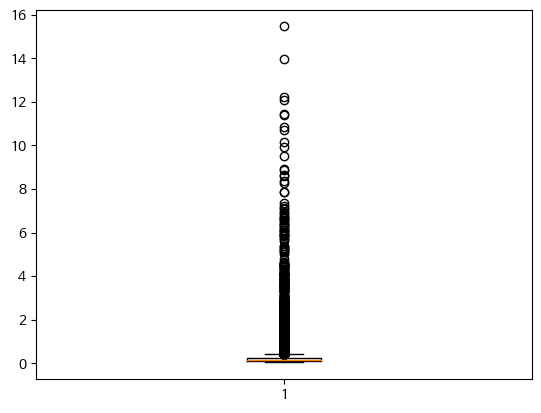

In [ ]:
plt.boxplot(df['s/m']) #:1m당 걸린 시간

In [ ]:
#전체 이상체 데이터프레임을 만들어보자.
q3 = df['s/m'].quantile(0.75)
q1 = df['s/m'].quantile(0.25)
q =  (q3-q1)*1.5+q3
outlier_all = df[df['s/m']>= q ]

#전체 데이터의 약 10퍼센트 정도...

In [ ]:
q

0.4406365884977709

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, '360-1'),
  Text(1, 0, '360-2'),
  Text(2, 0, '360-7'),
  Text(3, 0, '360-12'),
  Text(4, 0, '365-21'),
  Text(5, 0, '365-22'),
  Text(6, 0, '201-11'),
  Text(7, 0, '201-12'),
  Text(8, 0, '201-13'),
  Text(9, 0, '201-14'),
  Text(10, 0, '201-15'),
  Text(11, 0, '201-16'),
  Text(12, 0, '201-17'),
  Text(13, 0, '201-18'),
  Text(14, 0, '201-21'),
  Text(15, 0, '201-22'),
  Text(16, 0, '201-24'),
  Text(17, 0, '201-26'),
  Text(18, 0, '201-27'),
  Text(19, 0, '281-1'),
  Text(20, 0, '281-2')])

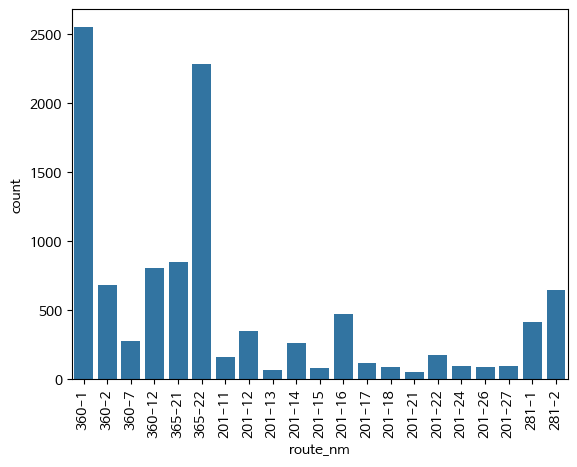

In [ ]:
sns.countplot(x = 'route_nm', data = outlier_all)
plt.xticks(rotation =90)

In [ ]:
outlier_count = outlier_all.groupby(['route_nm'])['route_nm'].count().reset_index(name='count')

In [ ]:
outlier_count

,route_nm,count
0,201-11,162
1,201-12,348
2,201-13,67
3,201-14,264
4,201-15,79
5,201-16,472
6,201-17,116
7,201-18,87
8,201-21,51
9,201-22,172


In [ ]:
outlier_count['count'].describe()

count      21.000000
mean      505.190476
std       686.135382
min        51.000000
25%        95.000000
50%       264.000000
75%       645.000000
max      2554.000000
Name: count, dtype: float64

In [ ]:
outlier_count[outlier_count['count']>=645]

,route_nm,count
14,281-2,645
15,360-1,2554
16,360-12,808
17,360-2,683
19,365-21,851
20,365-22,2284


이상치의 노선 별 개수를 세어 보니



1.   360-1
2.   360-2
3.   360-12
4.   365-21
5.   365-22
7.   281-2

6가지 노선들이 가장 이상치가 두드러지게 나타났고, 나머지 노선들의 이상치는 미미하였다.

-> 6개 노선들은 이상치를 처리하도록 한다.
-> 나머지 노선들은 이상치를 드랍한다.

In [ ]:
idx = df[((~df['route_nm'].isin(['281-2', '360-1', '360-12', '360-2', '365-21', '365-22'])) & (df['s/m'] >= q))].index
df.drop(idx, inplace =True)
df = df.reset_index(drop=True,inplace=False)

In [ ]:
df

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time
0,0,2019-10-15,405136001,7997025,360-1,제주대학교입구,06시,266.000000,제대마을,24,Tuesday,0.090226,11.083333,morning
1,1,2019-10-15,405136001,7997025,360-1,제대마을,06시,333.265436,제대아파트,36,Tuesday,0.108108,9.250000,morning
2,2,2019-10-15,405136001,7997025,360-1,제대아파트,06시,420.903308,제주대학교,40,Tuesday,0.096386,10.375000,morning
3,3,2019-10-15,405136001,7997025,360-1,남국원(아라방면),06시,578.000000,제주여자중고등학교(아라방면),42,Tuesday,0.072664,13.761905,morning
4,4,2019-10-15,405136001,7997025,360-1,도호동,07시,322.581998,은남동,64,Tuesday,0.171123,5.843750,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207668,210452,2019-10-28,405328102,7983486,281-2,비석거리,21시,526.655462,삼아아파트,96,Monday,0.181818,5.500000,evening
207669,210453,2019-10-28,405328102,7983486,281-2,동문로터리,21시,280.000000,매일올레시장 7번입구,50,Monday,0.178571,5.600000,evening
207670,210454,2019-10-28,405328102,7983486,281-2,서귀포시 구 버스터미널,21시,114.000000,아랑조을거리 입구,16,Monday,0.140351,7.125000,evening
207671,210455,2019-10-28,405328102,7983486,281-2,아랑조을거리 입구,21시,219.256538,평생학습관,38,Monday,0.170404,5.868421,evening


# 총 작업 내용



1.   필요하지 않은 열 삭제 (위도, 경도, id)
2.   같은 now_station과 next_station간의 거리 통일
3.   ['s/m']와 ['m/s'] 칼럼 추가
4.   시간을 3타임으로 나눈 오전, 오후, 저녁 칼럼 추가
5.   요일을 나타내는 칼럼 추가
6.   이상치의 개수가 1600개 미만인 버스들의 이상치 제거 (75%)



In [ ]:
# outlier의 count가 두드러졌던 6개 노선을 데이터프레임화 (변수명 : outlier_df)
# 이상치 대체와 삭제할 때 지표로 사용하기 위해, index를 df의 기존 index로 유지

outlier_df = df[(df['route_nm'].isin([ '281-2', '360-1', '360-12', '360-2', '365-21', '365-22'])) & (df['s/m']>q)]

In [ ]:
outlier_df

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time
9,9,2019-10-15,405136001,7997025,360-1,노형오거리,07시,252.0,남녕고등학교,204,Tuesday,0.809524,1.235294,morning
10,10,2019-10-15,405136001,7997025,360-1,남녕고등학교,07시,322.0,한라병원,156,Tuesday,0.484472,2.064103,morning
15,15,2019-10-15,405136001,7997025,360-1,도호동,08시,321.0,연동주민센터,184,Tuesday,0.573209,1.744565,morning
40,40,2019-10-15,405136001,7997025,360-1,원노형,10시,185.0,노형오거리,196,Tuesday,1.059459,0.943878,morning
42,42,2019-10-15,405136001,7997025,360-1,남녕고등학교,11시,322.0,한라병원,170,Tuesday,0.527950,1.894118,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207555,210339,2019-10-28,405328102,7983486,281-2,아라주공아파트,09시,328.0,아라동주민센터,150,Monday,0.457317,2.186667,morning
207584,210368,2019-10-28,405328102,7983486,281-2,아랑조을거리 입구,12시,114.0,서귀포시 구 버스터미널,148,Monday,1.298246,0.770270,afternoon
207589,210373,2019-10-28,405328102,7983486,281-2,주공 3 4단지,12시,312.0,삼아아파트,158,Monday,0.506410,1.974684,afternoon
207611,210395,2019-10-28,405328102,7983486,281-2,제주시청(광양방면),13시,418.0,광양사거리,218,Monday,0.521531,1.917431,afternoon


In [ ]:
outlier_count = outlier_df.groupby(['now_station','next_station'])['now_station'].count().reset_index(name = 'count')
outlier_count

,now_station,next_station,count
0,고산동산(광양방면),제주지방법원(광양방면),3
1,고산동산(아라방면),제주지방법원(아라방면),3
2,관덕정,서문시장,1
3,관덕정,중앙로(국민은행),22
4,광양,삼성초등학교,22
...,...,...,...
120,한라병원,월랑마을 남녕고등학교,1
121,한라중학교/부영아파트,대림2차아파트,25
122,홍랑로입구,용천마을,7
123,홍랑로입구,탐라장애인 종합복지관,5


In [ ]:
outlier_count.describe()

,count
count,125.000000
mean,62.600000
std,115.761086
min,1.000000
25%,3.000000
50%,7.000000
75%,56.000000
max,579.000000


In [ ]:
# outlier_df 중 노선 6개를 각각 뽑아 데이터프레임화 (변수명 : df노선번호)

df281_2 = outlier_df[outlier_df['route_nm'] == '281-2']
df360_1 = outlier_df[outlier_df['route_nm'] == '360-1']
df360_2 = outlier_df[outlier_df['route_nm'] == '360-2']
df360_12 = outlier_df[outlier_df['route_nm'] == '360-12']
df365_21 = outlier_df[outlier_df['route_nm'] == '365-21']
df365_22 = outlier_df[outlier_df['route_nm'] == '365-22']

In [ ]:
#  6개 노선의 데이터프레임의 정거장별 카운트값 데이터프레임화 (변수명 : count_노선번호)

count_281_2 = df281_2.groupby(['now_station', 'next_station'])['route_nm'].count().reset_index(name ='count')
count_360_1 = df360_1.groupby(['now_station', 'next_station'])['route_nm'].count().reset_index(name ='count')
count_360_2 = df360_2.groupby(['now_station', 'next_station'])['route_nm'].count().reset_index(name ='count')
count_360_12 = df360_12.groupby(['now_station', 'next_station'])['route_nm'].count().reset_index(name ='count')
count_365_21 = df365_21.groupby(['now_station', 'next_station'])['route_nm'].count().reset_index(name ='count')
count_365_22 = df365_22.groupby(['now_station', 'next_station'])['route_nm'].count().reset_index(name ='count')

<Figure size 1500x1000 with 0 Axes>

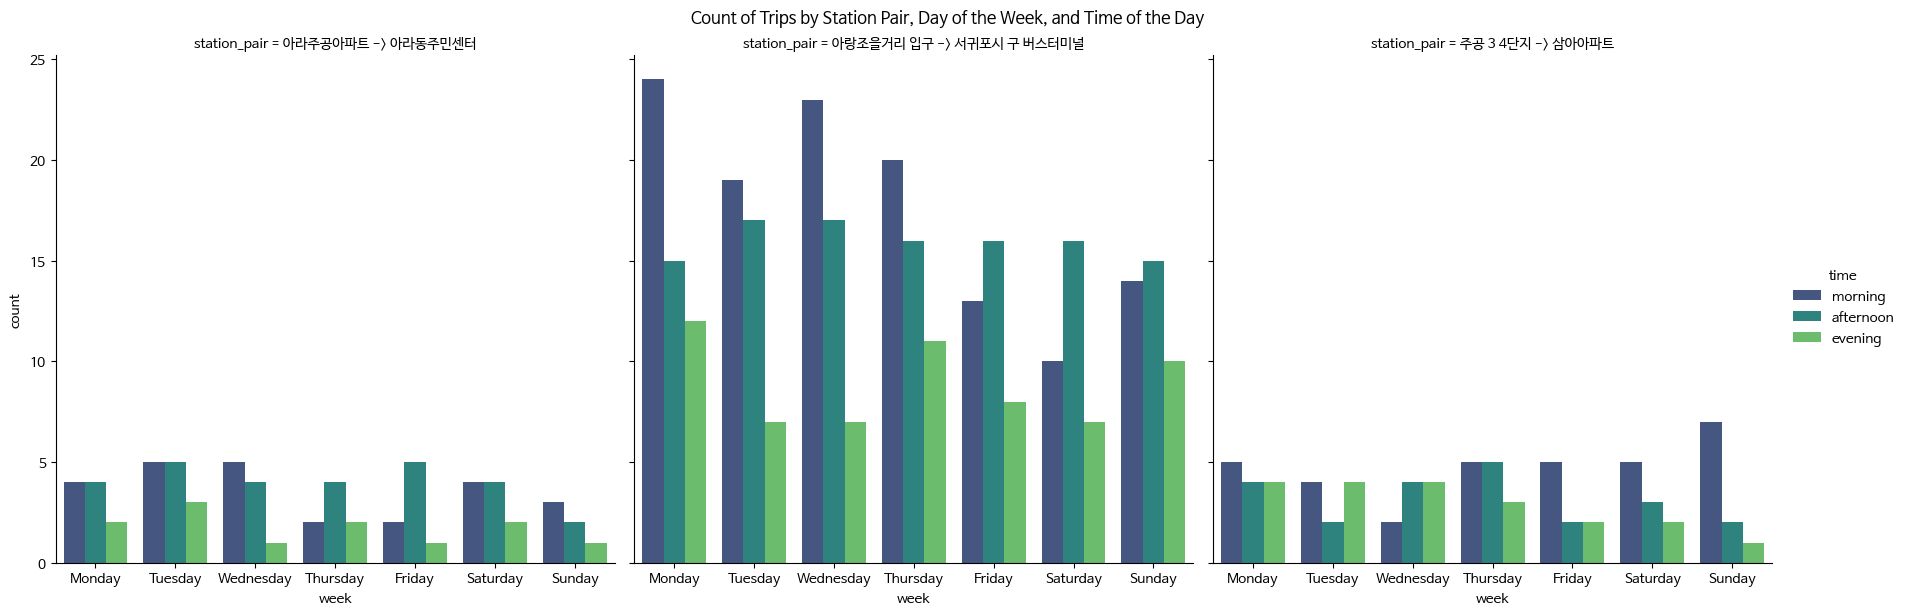

In [ ]:
# 281-2번의 count 64.75 이상 정류장의 요일별&시간대별 카운트의 시각화

over75_281_2 = count_281_2[count_281_2['count']>=56]
over75_281_2 = pd.merge(df281_2, over75_281_2, on = ['now_station', 'next_station'], how='inner')

# station_pair 열 추가
over75_281_2['station_pair'] = over75_281_2['now_station'] + ' -> ' + over75_281_2['next_station']

# 각 station_pair에 대한 요일별 데이터 수 계산
count_by_day_281_2 = over75_281_2.groupby(['station_pair', 'week','time'])['route_nm'].count().reset_index(name='count')

# 요일을 올바른 순서로 정렬
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_order = ['morning','afternoon','evening']
count_by_day_281_2['week'] = pd.Categorical(count_by_day_281_2['week'], categories=days_order, ordered=True)
count_by_day_281_2['time'] = pd.Categorical(count_by_day_281_2['time'], categories=times_order, ordered=True)
count_by_day_281_2 = count_by_day_281_2.sort_values(['station_pair', 'week','time'])


plt.figure(figsize=(15, 10))
sns.catplot(x='week', y='count', hue='time', col='station_pair', data=count_by_day_281_2, kind='bar', palette='viridis', height=6, aspect=1)
plt.suptitle('Count of Trips by Station Pair, Day of the Week, and Time of the Day', y=1.02)
plt.show()

<Figure size 1500x1000 with 0 Axes>

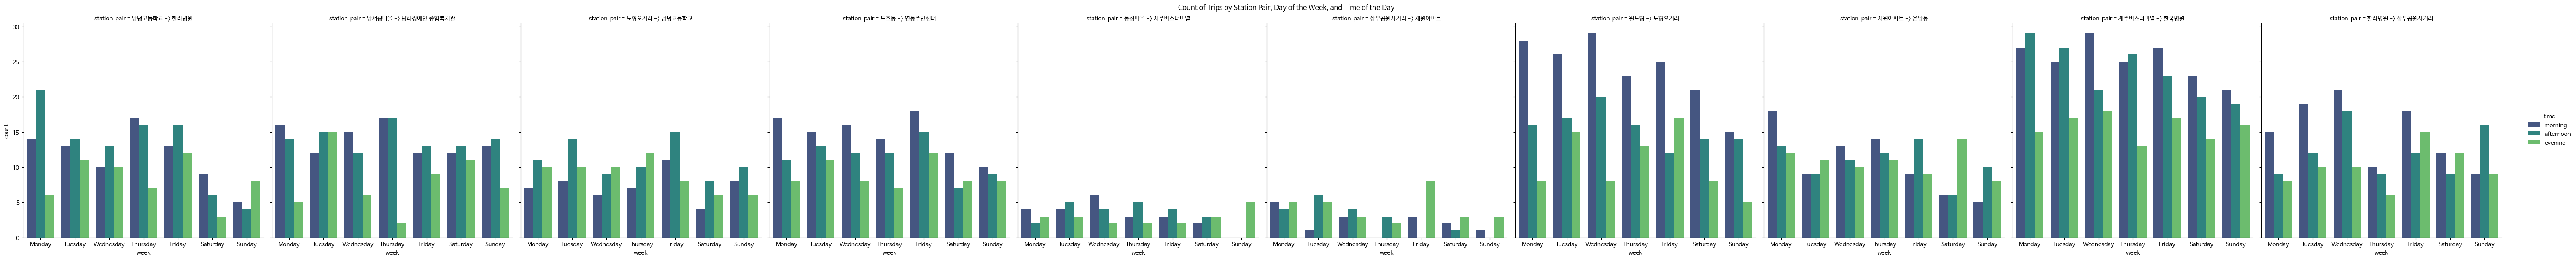

In [ ]:
# 360-1번의 count 64.75 이상 정류장의 요일별&시간대별 카운트의 시각화

over75_360_1 = count_360_1[count_360_1['count']>=56]
over75_360_1 = pd.merge(df360_1, over75_360_1, on = ['now_station', 'next_station'], how='inner')

# station_pair 열 추가
over75_360_1['station_pair'] = over75_360_1['now_station'] + ' -> ' + over75_360_1['next_station']

# 각 station_pair에 대한 요일별 데이터 수 계산
count_by_day_360_1 = over75_360_1.groupby(['station_pair', 'week','time'])['route_nm'].count().reset_index(name='count')

# 요일을 올바른 순서로 정렬
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_order = ['morning','afternoon','evening']
count_by_day_360_1['week'] = pd.Categorical(count_by_day_360_1['week'], categories=days_order, ordered=True)
count_by_day_360_1['time'] = pd.Categorical(count_by_day_360_1['time'], categories=times_order, ordered=True)
count_by_day_360_1 = count_by_day_360_1.sort_values(['station_pair', 'week','time'])


plt.figure(figsize=(15, 10))
sns.catplot(x='week', y='count', hue='time', col='station_pair', data=count_by_day_360_1, kind='bar', palette='viridis', height=6, aspect=1)
plt.suptitle('Count of Trips by Station Pair, Day of the Week, and Time of the Day', y=1.02)
plt.show()

Text(0.5, 1.02, 'Count of Trips by Station Pair, Day of the Week, and Time of the Day')

<Figure size 1500x1000 with 0 Axes>

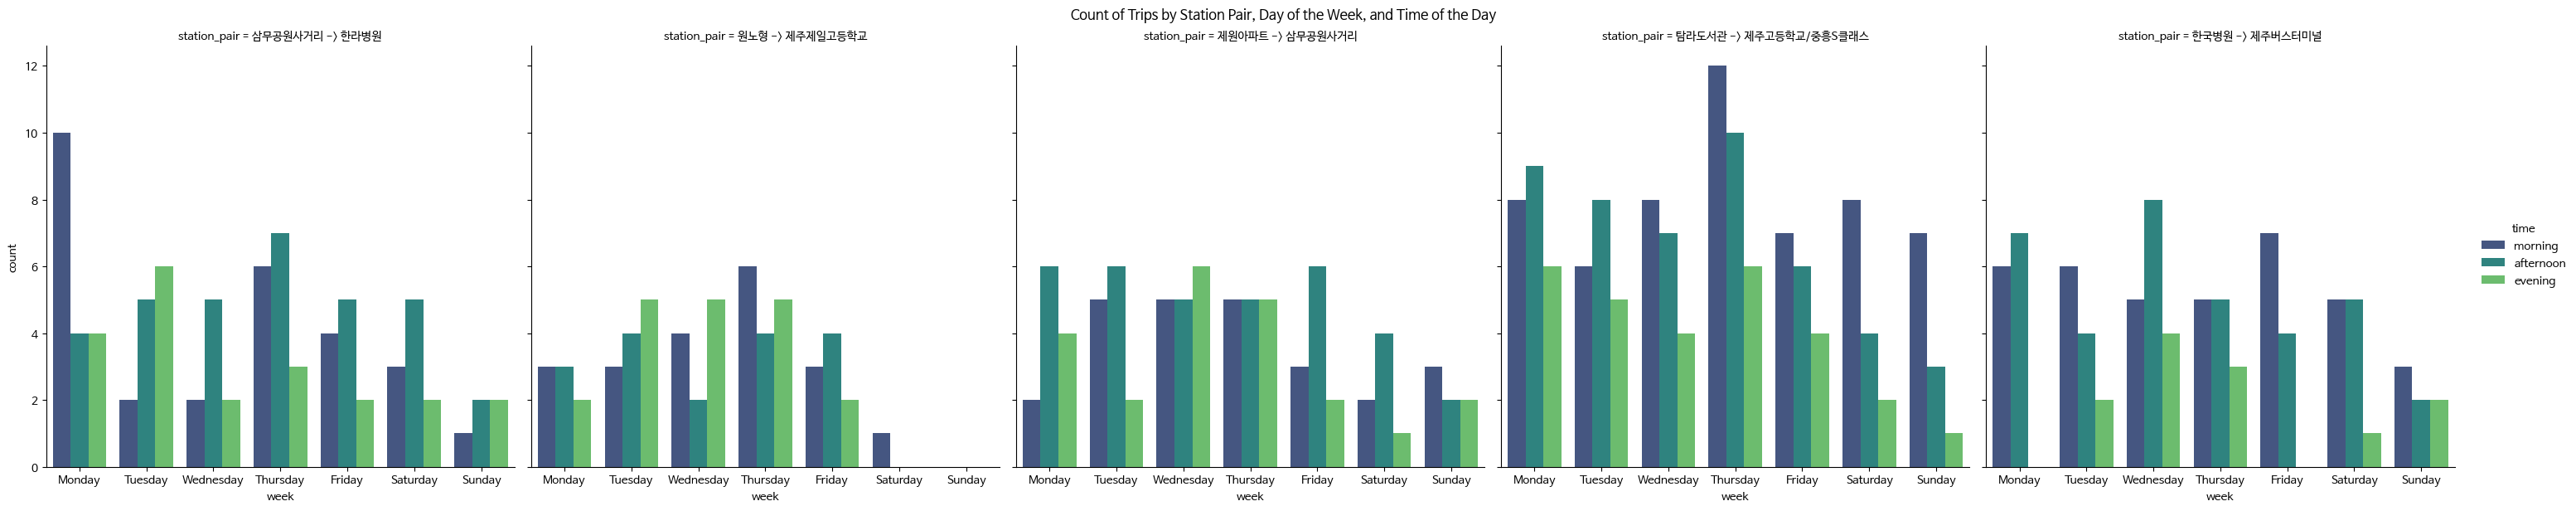

In [ ]:
# 360-2번의 count 64.75 이상 정류장의 요일별&시간대별 카운트의 시각화

over75_360_2 = count_360_2[count_360_2['count']>=56]
over75_360_2 = pd.merge(df360_2, over75_360_2, on = ['now_station', 'next_station'], how='inner')

# station_pair 열 추가
over75_360_2['station_pair'] = over75_360_2['now_station'] + ' -> ' + over75_360_2['next_station']

# 각 station_pair에 대한 요일별 데이터 수 계산
count_by_day_360_2 = over75_360_2.groupby(['station_pair', 'week','time'])['route_nm'].count().reset_index(name='count')

# 요일을 올바른 순서로 정렬
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_order = ['morning','afternoon','evening']
count_by_day_360_2['week'] = pd.Categorical(count_by_day_360_2['week'], categories=days_order, ordered=True)
count_by_day_360_2['time'] = pd.Categorical(count_by_day_360_2['time'], categories=times_order, ordered=True)
count_by_day_360_2 = count_by_day_360_2.sort_values(['station_pair', 'week','time'])



plt.figure(figsize=(15, 10))
sns.catplot(x='week', y='count', hue='time', col='station_pair', data=count_by_day_360_2, kind='bar', palette='viridis', height=6, aspect=1)
plt.suptitle('Count of Trips by Station Pair, Day of the Week, and Time of the Day', y=1.02)

<Figure size 1500x1000 with 0 Axes>

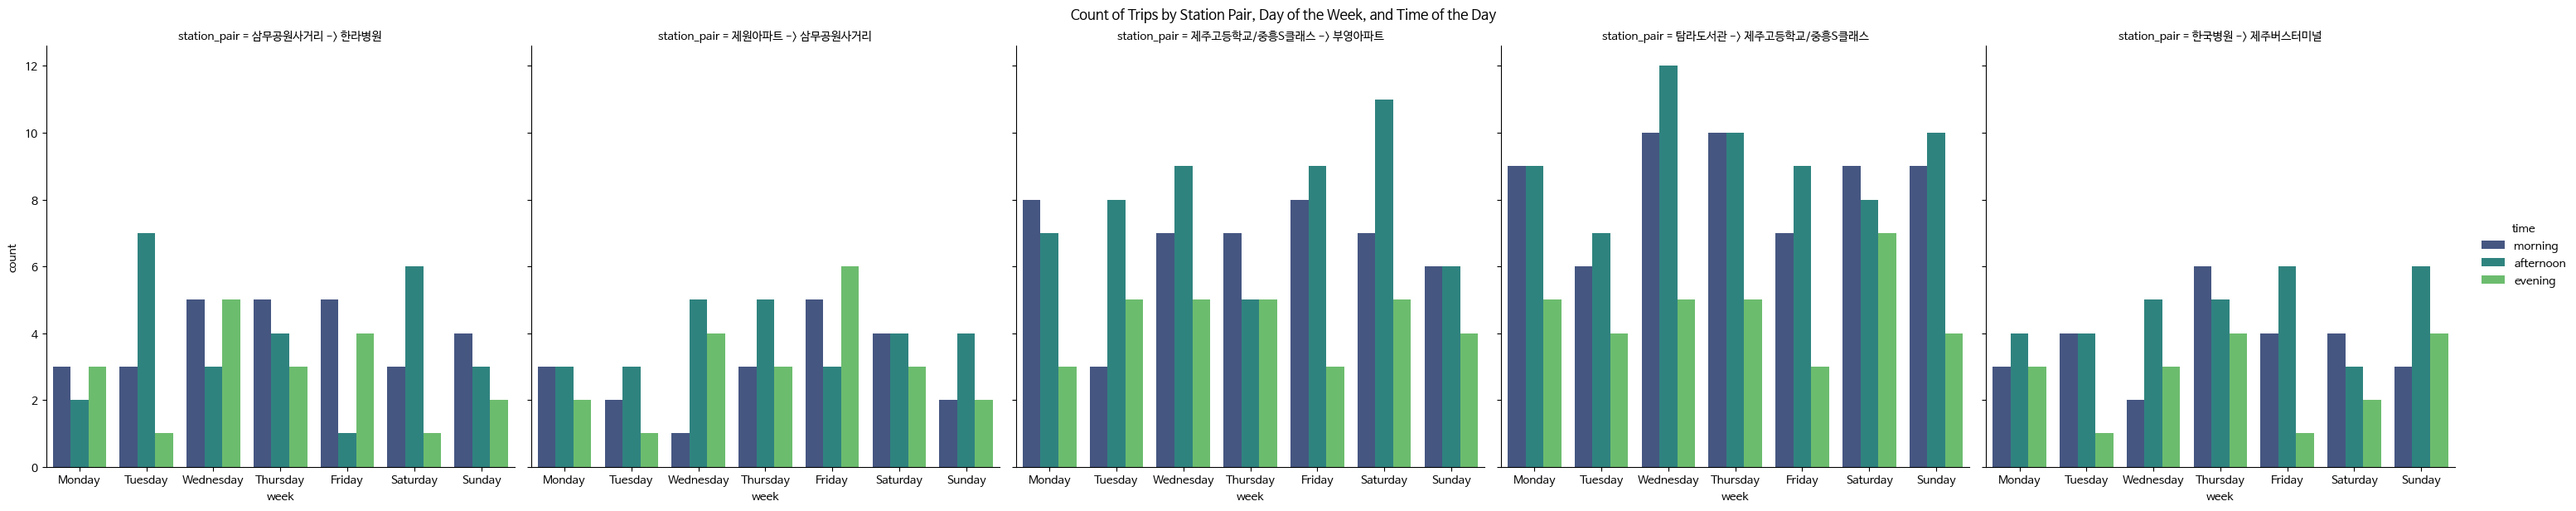

In [ ]:
# 360-12번의 count 64.75 이상 정류장의 요일별&시간대별 카운트의 시각화

over75_360_12 = count_360_12[count_360_12['count']>=56]
over75_360_12 = pd.merge(df360_12, over75_360_12, on = ['now_station', 'next_station'], how='inner')

# station_pair 열 추가
over75_360_12['station_pair'] = over75_360_12['now_station'] + ' -> ' + over75_360_12['next_station']

# 각 station_pair에 대한 요일별 데이터 수 계산
count_by_day_360_12 = over75_360_12.groupby(['station_pair', 'week','time'])['route_nm'].count().reset_index(name='count')

# 요일을 올바른 순서로 정렬
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_order = ['morning','afternoon','evening']
count_by_day_360_12['week'] = pd.Categorical(count_by_day_360_12['week'], categories=days_order, ordered=True)
count_by_day_360_12['time'] = pd.Categorical(count_by_day_360_12['time'], categories=times_order, ordered=True)
count_by_day_360_12 = count_by_day_360_12.sort_values(['station_pair', 'week','time'])



plt.figure(figsize=(15, 10))
sns.catplot(x='week', y='count', hue='time', col='station_pair', data=count_by_day_360_12, kind='bar', palette='viridis', height=6, aspect=1)
plt.suptitle('Count of Trips by Station Pair, Day of the Week, and Time of the Day', y=1.02)
plt.show()

<Figure size 1500x1000 with 0 Axes>

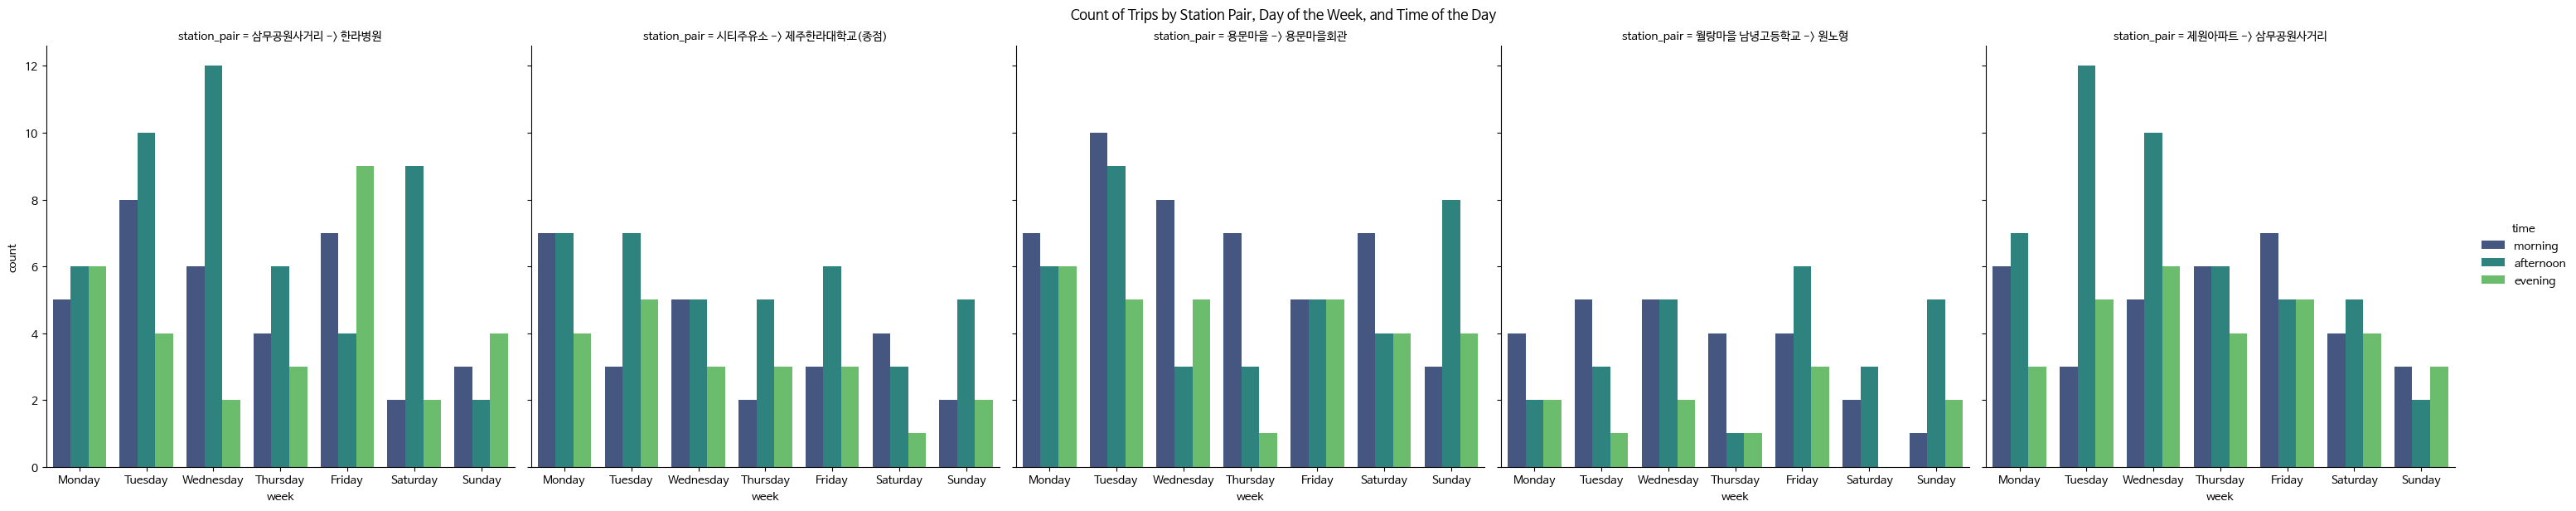

In [ ]:
# 365-21번의 count 64.75 이상 정류장의 요일별&시간대별 카운트의 시각화

over75_365_21 = count_365_21[count_365_21['count']>=56]
over75_365_21 = pd.merge(df365_21, over75_365_21, on = ['now_station', 'next_station'], how='inner')

# station_pair 열 추가
over75_365_21['station_pair'] = over75_365_21['now_station'] + ' -> ' + over75_365_21['next_station']

# 각 station_pair에 대한 요일별 데이터 수 계산
count_by_day_365_21 = over75_365_21.groupby(['station_pair', 'week','time'])['route_nm'].count().reset_index(name='count')

# 요일을 올바른 순서로 정렬
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_order = ['morning','afternoon','evening']
count_by_day_365_21['week'] = pd.Categorical(count_by_day_365_21['week'], categories=days_order, ordered=True)
count_by_day_365_21['time'] = pd.Categorical(count_by_day_365_21['time'], categories=times_order, ordered=True)
count_by_day_365_21 = count_by_day_365_21.sort_values(['station_pair', 'week','time'])


plt.figure(figsize=(15, 10))
sns.catplot(x='week', y='count', hue='time', col='station_pair', data=count_by_day_365_21, kind='bar', palette='viridis', height=6, aspect=1)
plt.suptitle('Count of Trips by Station Pair, Day of the Week, and Time of the Day', y=1.02)
plt.show()

<Figure size 1500x1000 with 0 Axes>

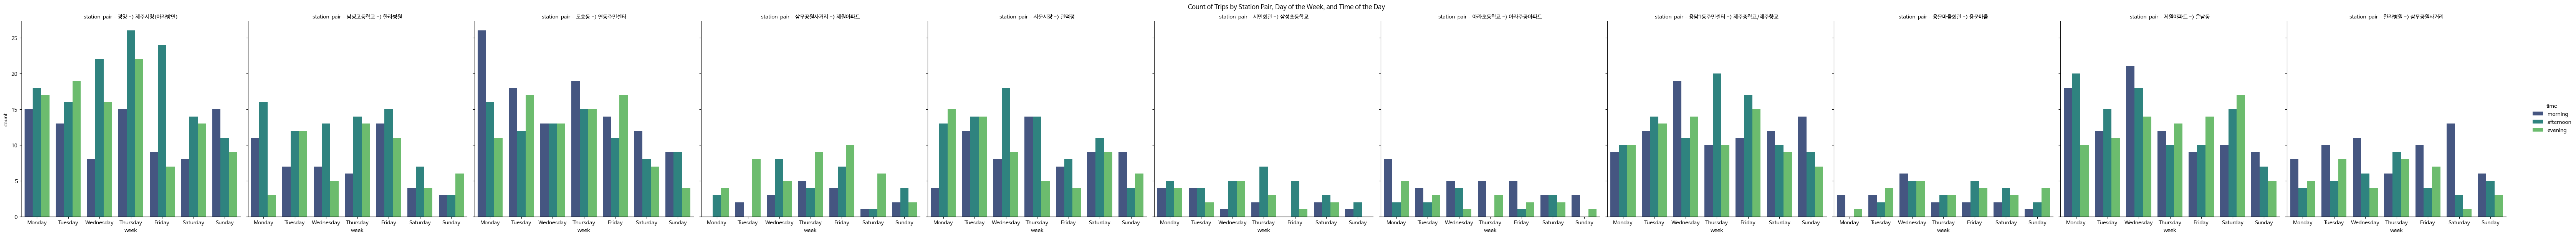

In [ ]:
# 365-22번의 count 64.75 이상 정류장의 요일별&시간대별 카운트의 시각화

over75_365_22 = count_365_22[count_365_22['count']>=56]
over75_365_22 = pd.merge(df365_22, over75_365_22, on = ['now_station', 'next_station'], how='inner')

# station_pair 열 추가
over75_365_22['station_pair'] = over75_365_22['now_station'] + ' -> ' + over75_365_22['next_station']

# 각 station_pair에 대한 요일별 데이터 수 계산
count_by_day_365_22 = over75_365_22.groupby(['station_pair', 'week','time'])['route_nm'].count().reset_index(name='count')

# 요일을 올바른 순서로 정렬
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_order = ['morning','afternoon','evening']
count_by_day_365_22['week'] = pd.Categorical(count_by_day_365_22['week'], categories=days_order, ordered=True)
count_by_day_365_22['time'] = pd.Categorical(count_by_day_365_22['time'], categories=times_order, ordered=True)
count_by_day_365_22 = count_by_day_365_22.sort_values(['station_pair', 'week','time'])


plt.figure(figsize=(15, 10))
sns.catplot(x='week', y='count', hue='time', col='station_pair', data=count_by_day_365_22, kind='bar', palette='viridis', height=6, aspect=1)
plt.suptitle('Count of Trips by Station Pair, Day of the Week, and Time of the Day', y=1.02)
plt.show()

# 1. 이상치 분석결과

- 각 노선들은 요일에 따른 차이는 크지 않았지만, 시간대별(아침, 점심, 저녁)에 따른 차이는 있었다.
- 시간대에 따른 가중치를 두는 것이 효과적이라 판단하였다.

----

# 2. 이상치 처리 방식

- 값들이 극단적으로 치우쳐져 있어, 평균보단 최댓값을 대치하는게 더 효과적이라 판단하였다.
- 각 노선별로 시간대별 최댓값으로 이상치를 대체하고자 한다.

----

# 3. 이상치 처리 단계
- 단계 1: outlier가 아닌 데이터들에서 해당 6개 노선들의 시간대별 최댓값 구하기
- 단계 2 : 최댓값 대체 (6개 노선 outlier의 count >= 56 인 경우)

- 단계 3 : 데이터 삭제 (6개 노선 outlier의 count < 56 인 경우)

### df에서 위의 6개 노선들의 outlier가 없는 데이터들만 뽑기 (변수명 : df_without_outliers6 )


In [ ]:
#outlier 없는 6개노선 df
df_without_outliers6 = df[(df['route_nm'].isin([ '281-2', '360-1', '360-12', '360-2', '365-21', '365-22'])) & (df['s/m']<=q)]

In [ ]:
df_without_outliers6

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time
0,0,2019-10-15,405136001,7997025,360-1,제주대학교입구,06시,266.000000,제대마을,24,Tuesday,0.090226,11.083333,morning
1,1,2019-10-15,405136001,7997025,360-1,제대마을,06시,333.265436,제대아파트,36,Tuesday,0.108108,9.250000,morning
2,2,2019-10-15,405136001,7997025,360-1,제대아파트,06시,420.903308,제주대학교,40,Tuesday,0.096386,10.375000,morning
3,3,2019-10-15,405136001,7997025,360-1,남국원(아라방면),06시,578.000000,제주여자중고등학교(아라방면),42,Tuesday,0.072664,13.761905,morning
4,4,2019-10-15,405136001,7997025,360-1,도호동,07시,322.581998,은남동,64,Tuesday,0.171123,5.843750,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207668,210452,2019-10-28,405328102,7983486,281-2,비석거리,21시,526.655462,삼아아파트,96,Monday,0.181818,5.500000,evening
207669,210453,2019-10-28,405328102,7983486,281-2,동문로터리,21시,280.000000,매일올레시장 7번입구,50,Monday,0.178571,5.600000,evening
207670,210454,2019-10-28,405328102,7983486,281-2,서귀포시 구 버스터미널,21시,114.000000,아랑조을거리 입구,16,Monday,0.140351,7.125000,evening
207671,210455,2019-10-28,405328102,7983486,281-2,아랑조을거리 입구,21시,219.256538,평생학습관,38,Monday,0.170404,5.868421,evening


## 6개 노선별로 시간대별 s/m의 최댓값 구하기
- 각 노선에 대한 결과를 변수에 할당 (변수명 :count_by_time_노선명 )

In [ ]:

# 281-2번

df_without_outliers281_2= df_without_outliers6[df_without_outliers6['route_nm'] == '281-2']


count_by_time_281_2 = df_without_outliers281_2.groupby(['time','s/m'])['route_nm'].count().reset_index(name='count')


times_order = ['morning','afternoon','evening']
count_by_time_281_2['time'] = pd.Categorical(count_by_time_281_2['time'], categories=times_order, ordered=True)
count_by_time_281_2 = count_by_time_281_2.sort_values(['time','s/m'])

count_by_time_281_2= count_by_time_281_2.groupby('time')['s/m'].max()

count_by_time_281_2= count_by_time_281_2.reset_index()
count_by_time_281_2.columns = ['time', 's/m']



# 360-1번

df_without_outliers360_1= df_without_outliers6[df_without_outliers6['route_nm'] == '360-1']


count_by_time_360_1 = df_without_outliers360_1.groupby(['time','s/m'])['route_nm'].count().reset_index(name='count')


times_order = ['morning','afternoon','evening']
count_by_time_360_1['time'] = pd.Categorical(count_by_time_360_1['time'], categories=times_order, ordered=True)
count_by_time_360_1 = count_by_time_360_1.sort_values(['time','s/m'])

count_by_time_360_1= count_by_time_360_1.groupby('time')['s/m'].max()

count_by_time_360_1= count_by_time_360_1.reset_index()
count_by_time_360_1.columns = ['time', 's/m']


# 360-2번

df_without_outliers360_2= df_without_outliers6[df_without_outliers6['route_nm'] == '360-2']


count_by_time_360_2 = df_without_outliers360_2.groupby(['time','s/m'])['route_nm'].count().reset_index(name='count')


times_order = ['morning','afternoon','evening']
count_by_time_360_2['time'] = pd.Categorical(count_by_time_360_2['time'], categories=times_order, ordered=True)
count_by_time_360_2 = count_by_time_360_2.sort_values(['time','s/m'])

count_by_time_360_2= count_by_time_360_2.groupby('time')['s/m'].max()

count_by_time_360_2= count_by_time_360_2.reset_index()
count_by_time_360_2.columns = ['time', 's/m']

# 360-12번

df_without_outliers360_12= df_without_outliers6[df_without_outliers6['route_nm'] == '360-12']


count_by_time_360_12 = df_without_outliers360_12.groupby(['time','s/m'])['route_nm'].count().reset_index(name='count')


times_order = ['morning','afternoon','evening']
count_by_time_360_12['time'] = pd.Categorical(count_by_time_360_12['time'], categories=times_order, ordered=True)
count_by_time_360_12 = count_by_time_360_12.sort_values(['time','s/m'])

count_by_time_360_12= count_by_time_360_12.groupby('time')['s/m'].max()

count_by_time_360_12= count_by_time_360_12.reset_index()
count_by_time_360_12.columns = ['time', 's/m']


# 365-21번

df_without_outliers365_21= df_without_outliers6[df_without_outliers6['route_nm'] == '365-21']


count_by_time_365_21 = df_without_outliers365_21.groupby(['time','s/m'])['route_nm'].count().reset_index(name='count')


times_order = ['morning','afternoon','evening']
count_by_time_365_21['time'] = pd.Categorical(count_by_time_365_21['time'], categories=times_order, ordered=True)
count_by_time_365_21 = count_by_time_365_21.sort_values(['time','s/m'])

count_by_time_365_21= count_by_time_365_21.groupby('time')['s/m'].max()

count_by_time_365_21= count_by_time_365_21.reset_index()
count_by_time_365_21.columns = ['time', 's/m']

# 365-22번

df_without_outliers365_22= df_without_outliers6[df_without_outliers6['route_nm'] == '365-22']


count_by_time_365_22 = df_without_outliers365_22.groupby(['time','s/m'])['route_nm'].count().reset_index(name='count')


times_order = ['morning','afternoon','evening']
count_by_time_365_22['time'] = pd.Categorical(count_by_time_365_22['time'], categories=times_order, ordered=True)
count_by_time_365_22 = count_by_time_365_22.sort_values(['time','s/m'])

count_by_time_365_22= count_by_time_365_22.groupby('time')['s/m'].max()

count_by_time_365_22= count_by_time_365_22.reset_index()
count_by_time_365_22.columns = ['time', 's/m']

In [ ]:
for i in range(0, 3):
    mask = (over75_281_2['time'] == count_by_time_281_2.iloc[i, 0])
    over75_281_2.loc[mask, 's/m'] = count_by_time_281_2.iloc[i, 1]

for i in range(0, 3):
    mask = (over75_360_1['time'] == count_by_time_360_1.iloc[i, 0])
    over75_360_1.loc[mask, 's/m'] = count_by_time_360_1.iloc[i, 1]

for i in range(0, 3):
    mask = (over75_360_2['time'] == count_by_time_360_2.iloc[i, 0])
    over75_360_2.loc[mask, 's/m'] = count_by_time_360_2.iloc[i, 1]

for i in range(0, 3):
    mask = (over75_360_12['time'] == count_by_time_360_12.iloc[i, 0])
    over75_360_12.loc[mask, 's/m'] = count_by_time_360_12.iloc[i, 1]

for i in range(0, 3):
    mask = (over75_365_21['time'] == count_by_time_365_21.iloc[i, 0])
    over75_365_21.loc[mask, 's/m'] = count_by_time_365_21.iloc[i, 1]

for i in range(0, 3):
    mask = (over75_365_22['time'] == count_by_time_365_22.iloc[i, 0])
    over75_365_22.loc[mask, 's/m'] = count_by_time_365_22.iloc[i, 1]


In [ ]:
df_without_outliers = df[df['s/m']<q]

In [ ]:
df_without_outliers

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time
0,0,2019-10-15,405136001,7997025,360-1,제주대학교입구,06시,266.000000,제대마을,24,Tuesday,0.090226,11.083333,morning
1,1,2019-10-15,405136001,7997025,360-1,제대마을,06시,333.265436,제대아파트,36,Tuesday,0.108108,9.250000,morning
2,2,2019-10-15,405136001,7997025,360-1,제대아파트,06시,420.903308,제주대학교,40,Tuesday,0.096386,10.375000,morning
3,3,2019-10-15,405136001,7997025,360-1,남국원(아라방면),06시,578.000000,제주여자중고등학교(아라방면),42,Tuesday,0.072664,13.761905,morning
4,4,2019-10-15,405136001,7997025,360-1,도호동,07시,322.581998,은남동,64,Tuesday,0.171123,5.843750,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207668,210452,2019-10-28,405328102,7983486,281-2,비석거리,21시,526.655462,삼아아파트,96,Monday,0.181818,5.500000,evening
207669,210453,2019-10-28,405328102,7983486,281-2,동문로터리,21시,280.000000,매일올레시장 7번입구,50,Monday,0.178571,5.600000,evening
207670,210454,2019-10-28,405328102,7983486,281-2,서귀포시 구 버스터미널,21시,114.000000,아랑조을거리 입구,16,Monday,0.140351,7.125000,evening
207671,210455,2019-10-28,405328102,7983486,281-2,아랑조을거리 입구,21시,219.256538,평생학습관,38,Monday,0.170404,5.868421,evening


In [ ]:
#new: 이상치 처리 된 6개 노선 데이터프레임을 모두 병합
new = pd.concat([over75_281_2, over75_360_1, over75_360_2, over75_360_12, over75_365_21, over75_365_22])

In [ ]:
new

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time,count,station_pair
0,14336,2019-10-15,405328102,7983400,281-2,아랑조을거리 입구,11시,114.0,서귀포시 구 버스터미널,54,Tuesday,0.439024,2.111111,morning,297,아랑조을거리 입구 -> 서귀포시 구 버스터미널
1,14384,2019-10-15,405328102,7983400,281-2,아랑조을거리 입구,15시,114.0,서귀포시 구 버스터미널,68,Tuesday,0.439024,1.676471,afternoon,297,아랑조을거리 입구 -> 서귀포시 구 버스터미널
2,14471,2019-10-15,405328102,7983406,281-2,아랑조을거리 입구,06시,114.0,서귀포시 구 버스터미널,110,Tuesday,0.439024,1.036364,morning,297,아랑조을거리 입구 -> 서귀포시 구 버스터미널
3,14511,2019-10-15,405328102,7983406,281-2,아랑조을거리 입구,10시,114.0,서귀포시 구 버스터미널,110,Tuesday,0.439024,1.036364,morning,297,아랑조을거리 입구 -> 서귀포시 구 버스터미널
4,14642,2019-10-15,405328102,7983409,281-2,아랑조을거리 입구,08시,114.0,서귀포시 구 버스터미널,58,Tuesday,0.439024,1.965517,morning,297,아랑조을거리 입구 -> 서귀포시 구 버스터미널
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,200061,2019-10-28,405136522,7997022,365-22,아라초등학교,19시,350.0,아라주공아파트,190,Monday,0.440252,1.842105,evening,62,아라초등학교 -> 아라주공아파트
1922,200273,2019-10-28,405136522,7997056,365-22,아라초등학교,11시,350.0,아라주공아파트,168,Monday,0.440129,2.083333,morning,62,아라초등학교 -> 아라주공아파트
1923,200378,2019-10-28,405136522,7997056,365-22,아라초등학교,22시,350.0,아라주공아파트,210,Monday,0.440252,1.666667,evening,62,아라초등학교 -> 아라주공아파트
1924,200822,2019-10-28,405136522,7997090,365-22,아라초등학교,13시,350.0,아라주공아파트,156,Monday,0.440129,2.243590,afternoon,62,아라초등학교 -> 아라주공아파트


In [ ]:
df_ver1 = pd.concat([df_without_outliers, new], axis = 0)

In [ ]:
df_ver1

,id,date,route_id,vh_id,route_nm,now_station,now_arrive_time,distance,next_station,next_arrive_time,week,s/m,m/s,time,count,station_pair
0,0,2019-10-15,405136001,7997025,360-1,제주대학교입구,06시,266.000000,제대마을,24,Tuesday,0.090226,11.083333,morning,NaN,NaN
1,1,2019-10-15,405136001,7997025,360-1,제대마을,06시,333.265436,제대아파트,36,Tuesday,0.108108,9.250000,morning,NaN,NaN
2,2,2019-10-15,405136001,7997025,360-1,제대아파트,06시,420.903308,제주대학교,40,Tuesday,0.096386,10.375000,morning,NaN,NaN
3,3,2019-10-15,405136001,7997025,360-1,남국원(아라방면),06시,578.000000,제주여자중고등학교(아라방면),42,Tuesday,0.072664,13.761905,morning,NaN,NaN
4,4,2019-10-15,405136001,7997025,360-1,도호동,07시,322.581998,은남동,64,Tuesday,0.171123,5.843750,morning,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,200061,2019-10-28,405136522,7997022,365-22,아라초등학교,19시,350.000000,아라주공아파트,190,Monday,0.440252,1.842105,evening,62.0,아라초등학교 -> 아라주공아파트
1922,200273,2019-10-28,405136522,7997056,365-22,아라초등학교,11시,350.000000,아라주공아파트,168,Monday,0.440129,2.083333,morning,62.0,아라초등학교 -> 아라주공아파트
1923,200378,2019-10-28,405136522,7997056,365-22,아라초등학교,22시,350.000000,아라주공아파트,210,Monday,0.440252,1.666667,evening,62.0,아라초등학교 -> 아라주공아파트
1924,200822,2019-10-28,405136522,7997090,365-22,아라초등학교,13시,350.000000,아라주공아파트,156,Monday,0.440129,2.243590,afternoon,62.0,아라초등학교 -> 아라주공아파트


In [ ]:
df_ver1.to_csv('df_ver1.csv')

# 2차 작업 정리 (주요 6개 노선 중심 작업)

1. 6개 노선에 대한 정류장별&요일별&시간대별 분석
2. outlier의 카운트가 56 이상인 경우: 해당 노선의 outlier가 아닌 값들의 최댓값으로 대체
3. outlier의 카운트가 56 미만인 경우: 의미없다 판단해, 기존 df에서 해당 데이터 삭제
